# Simple LangGraph Chatbot

This notebook demonstrates how to build a simple chatbot using LangGraph, a library for creating stateful multi-step conversational applications. We'll create a basic graph with a single chat node that processes messages using the OpenAI API.

## 1. Import Required Libraries

First, let's import all the necessary libraries for building our LangGraph chatbot:

In [16]:
import os
from dotenv import load_dotenv

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from pydantic import SecretStr
from IPython.display import Image, display

## 2. Load Environment Variables

Next, we'll load environment variables from a .env file. Make sure you have a .env file with your OPENAI_API_KEY defined.

In [17]:
# Load environment variables from .env file
load_dotenv()

True

## 3. Initialize the Language Model

Now, let's import and initialize the OpenAI language model that we'll use in our chatbot:

In [18]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=SecretStr(os.getenv("OPENAI_API_KEY") or ""),  # Ensure your API key is set in the environment
    temperature=0.0  # Set temperature to 0 for deterministic responses
)

## 4. Define State and Graph

Let's define the state structure using TypedDict and initialize our StateGraph:

In [19]:
class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]

# Initialize the StateGraph with our defined State
graph_builder = StateGraph(State)

## 5. Define Chatbot Node

Now, let's define the chatbot function that will process messages and return responses:

In [20]:
def chatbot(state: State):
    """
    This function processes the current state (messages) and returns a response from the language model.
    
    Args:
        state: The current state containing messages
        
    Returns:
        A dictionary with messages list containing the LLM's response
    """
    return {"messages": [llm.invoke(state["messages"])]}

## 6. Build and Compile the Graph

Let's add our chatbot node to the graph, set the entry and finish points, and compile the graph:

In [21]:
# Add the chatbot node to the graph
# The first argument is the unique node name
# The second argument is the function that will be called whenever the node is used
graph_builder.add_node("chatbot", chatbot)

# Set entry and finish points
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

# Compile the graph
graph = graph_builder.compile()

## 7. Visualize the Graph

Now let's visualize our simple graph structure using Mermaid. Note that this requires the `graphviz` package to be installed:

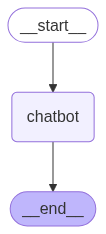

In [22]:
# Try to display the graph visualization
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not visualize graph: {e}")
    print("If you're missing graphviz, you can install it with: pip install graphviz")

## 8. Run the Chatbot

Let's test our chatbot by sending a message and displaying the response:

In [23]:
from langchain_core.messages import HumanMessage

# Create a human message
human_message = HumanMessage(content="Tell me a short joke about programming")

# Run the graph with our message
result = graph.invoke({"messages": [human_message]})

# Display the result
print("Bot response:")
print(result["messages"][-1].content)
print("------------")
print("result_struct: ", result)

Bot response:
Why do programmers prefer dark mode?

Because light attracts bugs!
------------
result_struct:  {'messages': [HumanMessage(content='Tell me a short joke about programming', additional_kwargs={}, response_metadata={}, id='9ec72d27-2bbb-44f9-a578-fcf39dc0c114'), AIMessage(content='Why do programmers prefer dark mode?\n\nBecause light attracts bugs!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 14, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BmTph2qPPXe4YTwTszq3abl3d4FLH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd4811ee-1a63-45c5-b2f4-1eece1f8632d-0', usage_metadata={'input_tokens': 14, 'output

## Custom node types
LangGraph allows you to create custom node types to implement complex agent logic. This provides flexibility and control over your application's behavior.

In [24]:
# Define a custom node that can be used in the graph
class MyCustomNode:
    def __init__(self, llm):
        self.llm = llm
    def __call__(self, state):
        # Implement your custom logic here
        # Access the state and perform actions
        messages = state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}
    
# Define a custom node that uses the LLM
graph_builder = StateGraph(State)
custom_node = MyCustomNode(llm)
graph_builder.add_node("custom_node", custom_node)

## Edge types
LangGraph supports different edge types to handle various communication patterns between nodes. One useful type is the conditional edge, which allows for decision-making based on a node's output.

To create a conditional edge, you need three components:

1. The upstream node: The node's output decides the next step.
2. A function: This function evaluates the upstream node's output and determines the next node to execute, returning a string that represents the decision.
3. A mapping: This mapping links the possible outcomes of the function to the corresponding nodes to be executed.

In [ ]:
graph.add_conditional_edge(
    "model",
    should_continue,
    {
        "end": END,
        "continue": "tools"
    }
)

## State management
LangGraph offers powerful state management techniques, which include using external databases like SQLite, PostgreSQL, and MongoDB, or cloud storage solutions like Amazon S3, Google Cloud Storage, and Azure Blob Storage to store and retrieve your agent's state, enabling reliability and scalability.

Here's an example of using a SQLite database for state management:

In [ ]:
from langgraph.persistence.sqlite import SqliteSaver
# Connect to the SQLite database
memory = SqliteSaver.from_conn_string(":memory:")
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)

ModuleNotFoundError: No module named 'langgraph.checkpoint.sqlite'

## Conclusion

We've successfully created a simple chatbot using LangGraph! This is a minimal example with just one node, but LangGraph allows you to build much more complex conversation flows with multiple nodes, conditional edges, and loops. You can extend this example by:

1. Adding more nodes for different conversation tasks
2. Implementing conditional routing between nodes
3. Adding memory to maintain context across multiple turns
4. Integrating tools and external APIs 
5. Creating feedback loops for self-correction

For more information, check out the [LangGraph documentation](https://github.com/langchain-ai/langgraph).